# Diffusion Model #
## Deffine:  ##
### Forward (noising) ###
$$
\begin{aligned}
α_t &= 1 - β_t \quad\quad \bar{α}_t = \prod_{i=1}^t α_i \\
x_t &= \sqrt{1-β_t}x_{t-1} + {β_t}ε \\
    &= \sqrt{α_t}x_{t-1} + \sqrt{1-α_t}ε \\
    &= \sqrt{{α_t}{α_{t-1}}}x_{t-2} + \sqrt{1-{α_t}{α_{t-1}}}ε \\
    &... \\
    &= \sqrt{\bar{α}_t}x_0 + \sqrt{1-\bar{α}_t}ε \quad (diffusion\space{}kernel) \\
\end{aligned}
$$
### Backward (denoising) ###

Variation Inference by Evidence Lower Bound (ELBO) 

变分推断找质性下界
1. Sample $$\begin{aligned} x_T \sim N(0,I) \end{aligned}$$
2. Iteratively sample $$\begin{aligned} x_{t-1} &\sim q(x_{t-1}|x_t) \\ &\propto q(x_{t-1})q(x_t|x_{t-1}) \end{aligned}$$
3. Use Gaussian distribution to approximate $$\begin{aligned} q&(x_{t-1}|x_t) \\ q&(x_{t-1}|x_t,x_0) \end{aligned}$$
4. Simplification $$\begin{aligned} q(x_{t-1}|x_t,x_0) &\sim N(x_{t-1}; \tilde{μ}_{t}(x_{t},x_0),\tilde{β}_{t}I) \\ \tilde{μ}_{t}(x_{t},x_0) &= \frac{\sqrt{α_t}(1-\bar{α}_{t-1})x_{t} + \sqrt{\bar{α}_{t-1}}(1-α_t)x_0}{1-\bar{α}_{t}} \\ &= \frac{\sqrt{α_t}(1-\bar{α}_{t-1})x_{t} + \sqrt{\bar{α}_{t-1}}β_{t}x_0}{1-\bar{α}_{t}} \\ &= \frac{\sqrt{α_t}(1-\bar{α}_{t-1})x_{t} + \sqrt{\bar{α}_{t-1}}β_{t}(\frac{x_{t}-\sqrt{1-\bar{α}_t}ε}{\sqrt{\bar{α}_t}})}{1-\bar{α}_{t}} \\ \tilde{β}_{t} &= \frac{(1-α_t)(1-\bar{α}_{t-1})}{1-\bar{α}_{t}} \\ &= \frac{β_{t}(1-\bar{α}_{t-1})}{1-\bar{α}_{t}} \end{aligned}$$

### Training and Sampling ###
#### Training according to simplified target (forward) ####
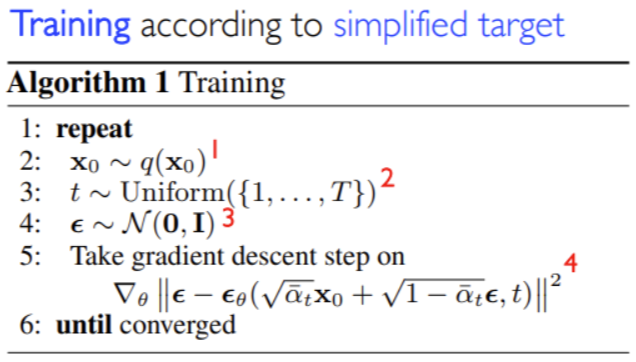
#### Sampling according to learned Gaussians (backward) ####
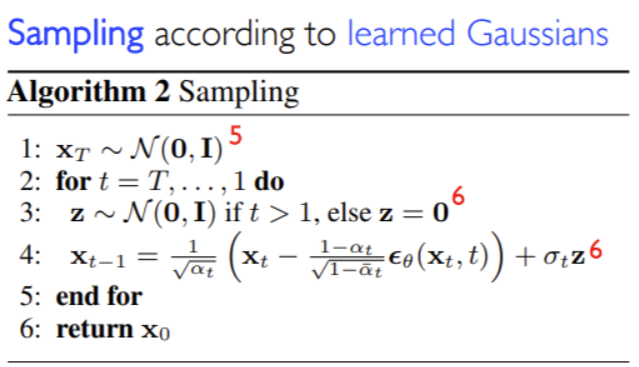

In [1]:
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


# 损失函数模块，实现绝对误差L1和均方误差L2
class WeightedLoss(nn.Module):
    def __init__(self):
        super(WeightedLoss, self).__init__()

    def forward(self, pred, targ, weighted=1.0):
        """
        pred, targ : [batch_size, action_dim]
        """
        loss = self._loss(pred, targ)
        WeightedLoss = (loss * weighted).mean()
        return WeightedLoss


class WeightedL1(WeightedLoss):
    def _loss(self, pred, targ):
        return torch.abs(pred - targ)


class WeightedL2(WeightedLoss):
    def _loss(self, pred, targ):
        return F.mse_loss(pred, targ, reduction="none")


Losses = {
    'l1': WeightedL1,
    'l2': WeightedL2,
}


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


# 位置编码模块，使用三角函数将时间步编码为向量
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# 去噪网络，使用多层感知机实现，包含时间编码和状态-动作编码，用于预测噪声
# U-Net: CNN-based (image) mid-layer -> conv. layers
class MLPDenoising(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, device, t_dim=16):
        super(MLPDenoising, self).__init__()
        self.t_dim = t_dim
        self.a_dim = action_dim
        self.device = device

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(t_dim),
            nn.Linear(t_dim, t_dim * 2),
            nn.Mish(),
            nn. Linear(t_dim * 2, t_dim),
        )

        input_dim = state_dim + action_dim + t_dim
        self.mid_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Mish(),
        )

        self.output_layer = nn.Linear(hidden_dim, action_dim)

        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, time, state):
        t_emb = self.time_mlp(time)
        x = torch.cat([x, state, t_emb], dim=1)
        x = self.mid_layer(x)
        return self.output_layer(x)
    

# 扩散网络，用于生成样本，包含初始化、前向、反向、采样和训练
class Diffusion(nn.Module):
    def __init__(self, loss_type, beta_schedule="linear", clip_denoised=True, predict_epsilon=True, **kwargs):
        super(Diffusion, self).__init__()
        self.state_dim = kwargs["obs_dim"]
        self.action_dim = kwargs["act_dim"]
        self.hidden_dim = kwargs["hidden_dim"]
        self.device = torch.device(kwargs["device"])
        self.T = kwargs["time_steps"]
        self.model = MLPDenoising(self.state_dim, self.action_dim, self.hidden_dim, self.device)

        if beta_schedule == "linear": # β_t
            betas = torch.linspace(1e-4, 0.02, self.T, dtype=torch.float32)
        # elif beta_schedule == "cosine":

        alphas = 1.0 - betas # α_t
        alphas_cumprod = torch.cumprod(alphas, dim=0) # bar-α_{t} = {t}Πα_i 
        alphas_cumprod_prev = torch.cat([torch.ones(1), alphas_cumprod[:-1]]) # bar-α_{t-1} ={t-1}Πα_i

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("alphas_cumprod_prev", alphas_cumprod_prev)

        # forward
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod))
        
        # backward
        posterior_var = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        self.register_buffer("posterior_var", posterior_var)
        self.register_buffer("posterior_log_var_clip", torch.log(posterior_var.clamp(min=1e-20)))
        
        self.register_buffer("sqrt_recip_alphas_cumprod", torch.sqrt(1.0 / alphas_cumprod))
        self.register_buffer("sqrt_recipm1_alphas_cumprod", torch.sqrt((1.0 / alphas_cumprod) - 1))
        
        self.register_buffer("posterior_mean_coef1", (1.0 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1.0 - alphas_cumprod))
        self.register_buffer("posterior_mean_coef2", betas * torch.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod))

        self.loss_fn = Losses[loss_type]()
    
    # Sampling, backward, predict x_init
    def q_posterior(self, x_init, x, t): # get posterior mean and variance
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x.shape) * x
                + extract(self.posterior_mean_coef2, t, x.shape) * x_init
        )
        posterior_var = extract(self.posterior_var, t, x.shape)
        posterior_log_var = extract(self.posterior_log_var_clip, t, x.shape)
        return posterior_mean, posterior_var, posterior_log_var

    def predict_init_from_noise(self, x, t, pred_noise): # get x_0 from x_t and ε
        return (extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
                - extract(self.sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise)

    def p_mean_variance(self, x, t, state):
        pred_noise = self.model(x, t, state) # ε
        x_init = self.predict_init_from_noise(x, t, pred_noise)
        x_init.clamp_(-1, 1)
        model_mean, posterior_var, posterior_log_var = self.q_posterior(x_init, x, t)
        return model_mean, posterior_log_var

    def p_sample(self, x, t, state): # sampling, find posterior mean and variance
        batch_size , *_, device = *x.shape, x.device
        model_mean, model_log_variance = self.p_mean_variance(x, t, state)
        noise = torch.randn_like(x)
        
        nonzero_mask = (1 - (t == 0).float()).reshape(batch_size, *((1,)*(len(x.shape)-1)))
        # 创建长度为 x_dim -1 的元组, 每个元素都为 1, 最终reshape结果为 (batch_size, 1, 1, ..., 1)
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    def p_sample_loop(self, state, shape, *args, **kwargs):
        device = self.device
        batch_size = state.shape[0]
        x = torch.randn(shape, device=device, requires_grad=False) # standard DDPM: False

        for i in reversed(range(0, self.T)):
            t = torch.full((batch_size, ), i, device=device, dtype=torch.long)
            x = self.p_sample(x, t, state)
        
        return x

    def sample(self, state, *args, **kwargs):
        """
        state : [batch_size, state_dim]
        """
        batch_size = state.shape[0]
        shape = [batch_size, self.action_dim]
        action = self.p_sample_loop(state, shape, *args, **kwargs)
        return action.clamp_(-1, 1)
    
    # Training, forward, compute loss/x_t
    def q_sample(self, x_init, t, noise):
        sample = (
            extract(self.sqrt_alphas_cumprod, t, x_init.shape) * x_init
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_init.shape) * noise
        )
        return sample
    
    def p_losses(self, x_init, state, t, weights=1.0):
        noise = torch.randn_like(x_init)
        x_noisy = self.q_sample(x_init, t, noise)
        x_recon = self.model(x_noisy, t, state)

        loss = self.loss_fn(x_recon, noise, weights)
        return loss
    
    def loss(self, x, state, weights=1.0):
        batch_size = len(x)
        t = torch.randint(0, self.T, (batch_size,), device=self.device).long()
        return self.p_losses(x, state, t, weights)

    def forward(self, state, *args, **kwargs):
        return self.sample(state, *args, **kwargs)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("device: ", device)
x = torch.randn(256,2).to(device)
state = torch.randn(256,11).to(device)
model = Diffusion(loss_type="l2", obs_dim=11, act_dim=2, hidden_dim=256, time_steps=100, device=device).to(device)

action = model(state).to(device)
loss = model.loss(x, state)

print(f"action: {action}; loss: {loss.item()}")

device:  cuda


C:\Users\31263\AppData\Local\Temp\ipykernel_11516\749508985.py:94: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(m.weight)


action: tensor([[ 0.6516,  0.0141],
        [-0.6252, -0.5042],
        [ 0.9897,  0.7906],
        [ 0.9998,  0.9985],
        [-0.8296,  0.7454],
        [ 0.7118,  0.4068],
        [ 0.3322, -0.8664],
        [ 0.9350,  0.9906],
        [ 0.2190, -0.3836],
        [ 0.5789,  0.6521],
        [-0.9998,  0.5902],
        [ 0.9977, -0.0740],
        [-0.3469, -0.9868],
        [ 0.9998,  0.9998],
        [ 0.8261,  0.5867],
        [-0.2789,  0.9853],
        [-0.2846,  0.7551],
        [-0.4395,  0.9357],
        [-0.9208,  0.7551],
        [-0.7930, -0.9356],
        [-0.0852, -0.9956],
        [ 0.9998,  0.9957],
        [-0.9998,  0.7900],
        [-0.0298,  0.9930],
        [ 0.3424,  0.8027],
        [-0.2237,  0.6117],
        [-0.0847, -0.0257],
        [-0.9460, -0.9891],
        [-0.9423,  0.4374],
        [ 0.8267,  0.8793],
        [ 0.8629, -0.1637],
        [-0.9981, -0.9998],
        [ 0.9998,  0.9238],
        [-0.6459,  0.9998],
        [ 0.5470,  0.9414],
        [ 0.

# DiT (Diffusion Models with Transformers) # \
https://github.com/facebookresearch/DiT/blob/main/models.py

**DiT Block with adaLN-Zero** \
通常的 LayerNorm: scale/gamma, shift/beta 参数需要自学习

DiT Block (with adaLN_Zero): 这里的 adaLN-Zero 是一种自适应归一化技术，全称为 Adaptive Layer Normalization with Zero Initialization。它通过一个多层感知机（MLP）从条件信息（如文本嵌入）中动态预测层归一化（LayerNorm）的缩放（gamma）和平移（beta）参数，从而对输入进行归一化。与传统的自适应归一化不同，adaLN-Zero 在初始化时将缩放参数设为零，然后在训练过程中逐步学习这些参数。这种设计有助于提高模型的训练稳定性，同时增强模型对条件信息的适应能力，从而提升整体性能。
注: 使用 Cross-Attention 的话计算复杂量会太大

**Schematic** \
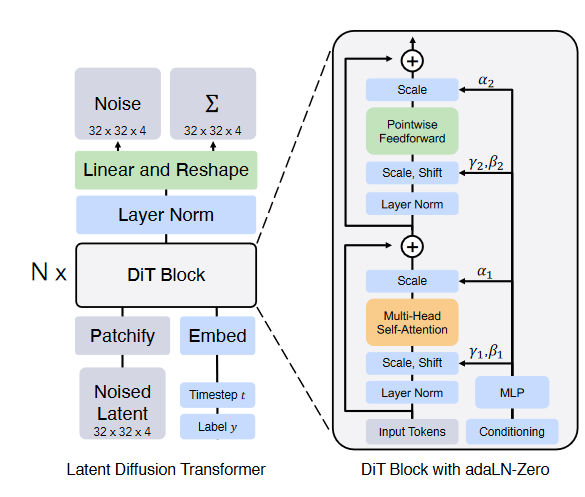



In [3]:
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp # 直接调用其他 cv transformer 模型里的 PatchEmbedder, MHA 和 Pointwise Feedforward

test_PatchEmbed = PatchEmbed(img_size=224, patch_size=16, in_chans=3, embed_dim=768)
test_Attention = Attention(dim=256, num_heads=8, qkv_bias=True, attn_drop=0.0, proj_drop=0.0)
test_Mlp = Mlp(in_features=256, hidden_features=1024, out_features=256, act_layer=nn.SiLU, drop=0.0)
print(test_PatchEmbed)
print(test_Attention)
print(test_Mlp)

del test_PatchEmbed, test_Attention, test_Mlp

e:\Production\Programing\Env\anaconda3_2022.10\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)
Attention(
  (qkv): Linear(in_features=256, out_features=768, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=256, out_features=256, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
Mlp(
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (act): SiLU()
  (drop1): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (drop2): Dropout(p=0.0, inplace=False)
)


### Embedders ###

In [4]:
class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_dim, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_dim, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True)   
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_dim, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_dim)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


TestLabelEmbedder = LabelEmbedder(1000, 512, 0.1)
print(TestLabelEmbedder)

TestTimestepEmbedder = TimestepEmbedder(512, 256)
print(TestTimestepEmbedder)

LabelEmbedder(
  (embedding_table): Embedding(1001, 512)
)
TimestepEmbedder(
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
)


In [5]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos): # 根据输入的位置和维度生成 1D 的正弦余弦位置嵌入
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid): # 基于 1D 的位置嵌入生成 2D 的位置嵌入
    assert embed_dim % 2 == 0 

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0): # 根据网格大小生成 2D 的位置嵌入
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed
    


### DiT Block ###

In [30]:


def modulate(x, gamma, beta): # input tokens modulation
    """
    x: [bs, seq_len, dim]
    gamma: [bs, dim]
    beta: [bs, dim]
    """
    # gamma (scale) and beta(shift) modulation
    return x * (1 + gamma.unsqueeze(1)) + beta.unsqueeze(1)

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_dim, num_heads, mlp_ratio=4.0):
        super(DiTBlock, self).__init__()
        # 1st LayerNorm
        self.ln1 = nn.LayerNorm(hidden_dim, elementwise_affine=False, eps=1e-6)
        # MHA
        self.mha = Attention(hidden_dim, num_heads=num_heads, qkv_bias=True)
        # 2nd LayerNorm
        self.ln2 = nn.LayerNorm(hidden_dim, elementwise_affine=False, eps=1e-6)
        
        mlp_hidden_dim = int(hidden_dim * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate='tanh')
        # mlp / Pointwise Feedforward
        self.mlp = Mlp(in_features=hidden_dim, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)

        # gamma, beta parameters for LayerNorms
        # 会在 DiT 中初始化权重
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_dim, 6 * hidden_dim, bias=True) # 2 LayerNorm, 2 gates: 2 * 2h + 2h
        )

    def forward(self, x, c):
        #   β1         γ1         α1        β2         γ2         α2
        beta_mha, gamma_mha, alpha_mha, beta_mlp, gamma_mlp, alpha_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        # residual connection
        #   x     +   normed(x).scaled(gamma).shifted(beta).mha().scaled(alpha)
        x = x + self.mha(modulate(self.ln1(x), gamma_mha, beta_mha)) * alpha_mha.unsqueeze(1)
        x = x + self.mlp(modulate(self.ln2(x), gamma_mlp, beta_mlp)) * alpha_mlp.unsqueeze(1)
        return x
    

TestDiTBlock = DiTBlock(hidden_dim=256, num_heads=8)
print(TestDiTBlock)

DiTBlock(
  (ln1): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
  (mha): Attention(
    (qkv): Linear(in_features=256, out_features=768, bias=True)
    (q_norm): Identity()
    (k_norm): Identity()
    (attn_drop): Dropout(p=0.0, inplace=False)
    (proj): Linear(in_features=256, out_features=256, bias=True)
    (proj_drop): Dropout(p=0.0, inplace=False)
  )
  (ln2): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
  (mlp): Mlp(
    (fc1): Linear(in_features=256, out_features=1024, bias=True)
    (act): GELU(approximate='tanh')
    (drop1): Dropout(p=0, inplace=False)
    (norm): Identity()
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (drop2): Dropout(p=0, inplace=False)
  )
  (adaLN_modulation): Sequential(
    (0): SiLU()
    (1): Linear(in_features=256, out_features=1536, bias=True)
  )
)


In [34]:
class FinalLayer(nn.Module):
    """
    The final layer of DiT.
        hidden_dim: the dimension of the input tokens
        patch_size: the size of the input patches
        out_channels: the number of output channels
    """
    def __init__(self, hidden_dim, patch_size, out_channels):
        super(FinalLayer, self).__init__()
        self.fln = nn.LayerNorm(hidden_dim, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_dim, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_dim, 2 * hidden_dim, bias=True) # 1 LayerNorm: 2h
        )

    def forward(self, x, c):
        beta, gamma = self.adaLN_modulation(c).chunk(2, dim=1)
        x = self.linear(modulate(self.fln(x), gamma, beta))
        return x
    

TestFinalLayer = FinalLayer(hidden_dim=256, patch_size=16, out_channels=3)
print(TestFinalLayer)

FinalLayer(
  (fln): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
  (linear): Linear(in_features=256, out_features=768, bias=True)
  (adaLN_modulation): Sequential(
    (0): SiLU()
    (1): Linear(in_features=256, out_features=512, bias=True)
  )
)


In [48]:
class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    条件生成或无条件生成
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0, # 维度扩展比例
        class_dropout_prob=0.1,
        num_classes=1000, # 条件生成时使用
        learn_sigma=True, # 是否学习扩散噪声的方差
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.patch_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.time_embedder = TimestepEmbedder(hidden_size)
        self.label_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.patch_embedder.num_patches

        # 位置编码, 在初始化中会被固定为 sin-cos 编码
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)

        # 权重初始化 -> 训练初期有更稳定的表现 -> 减少训练迭代 （**不必要）
        # 如前面提到的 adaLN_zero initialization
        # self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.patch_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.patch_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.label_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.time_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.time_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x): # patch output -> 还原 img
        """
        x: (N, T, patch_size**2 * C) = (bs, num_patchs, ipx/patch, channels) # T 必须为完全平方数
        imgs: (N, H, W, C) = (bs, height, width, channels)
        """
        c = self.out_channels
        p = self.patch_embedder.patch_size[0] # ipx / patch
        h = w = int(x.shape[1] ** 0.5) # T patches -> T ** 0.5 patches / row and col
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x) # (n, c, h, p, w, p)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """ 
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.patch_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.time_embedder(t)                   # (N, D)
        y = self.label_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)   ==>   ALPHA, BETA, GAMMA
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)
    


In [72]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# 加载图片
def img_load(image_path: str, batch_size: int, shape: tuple = (32, 32)):
    image = Image.open(image_path).convert("RGB")  # 确保是 RGB 模式

    # 调整图片大小并转换为张量
    transform = transforms.Compose([
        transforms.Resize(shape),  # 调整为模型输入尺寸
        transforms.ToTensor()        # 转换为张量 [C, H, W]
    ])
    x_single = transform(image)  # 单张图片张量 [3, 32, 32]

    # 增加批量维度并扩展为批量大小
    x = x_single.unsqueeze(0).repeat(batch_size, 1, 1, 1)  # [8, 3, 32, 32]

    return x


model = DiT(
    input_size=32,
    patch_size=16,
    in_channels=3,
    hidden_size=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4.0,
    class_dropout_prob=0.1,
    num_classes=10,  # 假设我们使用一个有10类的条件生成任务
    learn_sigma=True,
)

batch_size = 8
img_path = r"D:\31263\Pictures\01C6E91A13F9D66A9701DE0092E43B24.jpg"
x = img_load(img_path, batch_size, shape=(32, 32))
t = torch.randint(0, 1000, (batch_size,))  # 扩散时间步 (N,)
y = torch.randint(0, 10, (batch_size,))  # 类别标签 (N,)

print(x.shape, t.shape, y.shape)

output = model(x, t, y)
print("Output shape:", output.shape)  # (N, out_channels, H, W)
print(output)
# cfg_scale = 5.0
# output_with_cfg = model.forward_with_cfg(torch.cat([x, x], dim=0), t, y, cfg_scale)
# print("Output with CFG shape:", output_with_cfg.shape)  # (2N, out_channels, H, W)

torch.Size([8, 3, 32, 32]) torch.Size([8]) torch.Size([8])
Output shape: torch.Size([8, 6, 32, 32])
tensor([[[[ 3.3285e-01, -3.8374e-01,  5.1562e-01,  ...,  2.6141e-01,
           -1.0337e+00, -4.4138e-01],
          [ 3.1907e-01,  3.7428e-01,  1.7912e-01,  ..., -1.8163e-01,
           -2.6486e-01, -1.5711e+00],
          [ 8.0071e-01,  3.0023e-01, -2.4521e-02,  ..., -1.1779e+00,
            4.7118e-01,  6.8704e-01],
          ...,
          [ 6.6814e-01, -1.0169e+00,  8.1698e-01,  ...,  1.4144e-02,
           -8.4114e-01,  2.5666e-01],
          [ 1.3116e-02, -4.8149e-01,  3.1276e-01,  ...,  1.0001e+00,
           -1.0109e-01,  3.1790e-02],
          [-6.9637e-02, -2.4451e-01,  6.8938e-01,  ..., -8.4779e-01,
            1.1362e-01, -3.9317e-01]],

         [[ 3.2649e-01, -7.1152e-01,  4.7960e-01,  ...,  3.9543e-01,
           -3.7114e-01,  3.8947e-01],
          [ 4.8257e-02, -8.0609e-01, -8.3117e-01,  ...,  4.1329e-01,
            1.5198e-01, -8.4936e-01],
          [-1.4362e-01, -3.

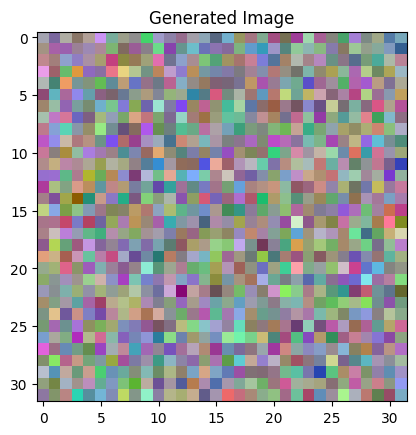

In [73]:
import matplotlib.pyplot as plt

# 提取第一张图片的后 3 通道作为 RGB 图像
output_image = output[0,:3].permute(1, 2, 0).detach().cpu().numpy()

# 可视化图像
plt.imshow((output_image - output_image.min()) / (output_image.max() - output_image.min()))
plt.title("Generated Image")
plt.show()